# Social Reward Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

import importlib
import helpful_functions
importlib.reload(helpful_functions)



<module 'helpful_functions' from '/data/neuron/SCN/SR/code/hpopal/helpful_functions.py'>

### Set directories and import subject data

In [2]:
#bids_dir = '/data/projects/social_doors/'
bids_dir = '/data/neuron/SCN/SR/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','rl_modeling')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants_good.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
subjs_info = subjs_info.loc[subjs_list]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 52 non-autistic participants
Found 21 autistic participants


# Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

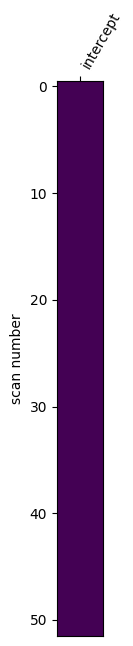

In [3]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [13]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['RPE','RPE_abs','ButtonPress']
group = 'not_asd'
tasks = ['SR']
alpha = 0.005
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        

Calculating group RPE contrast


/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.888821240041943. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group RPE_abs contrast
Calculating group ButtonPress contrast


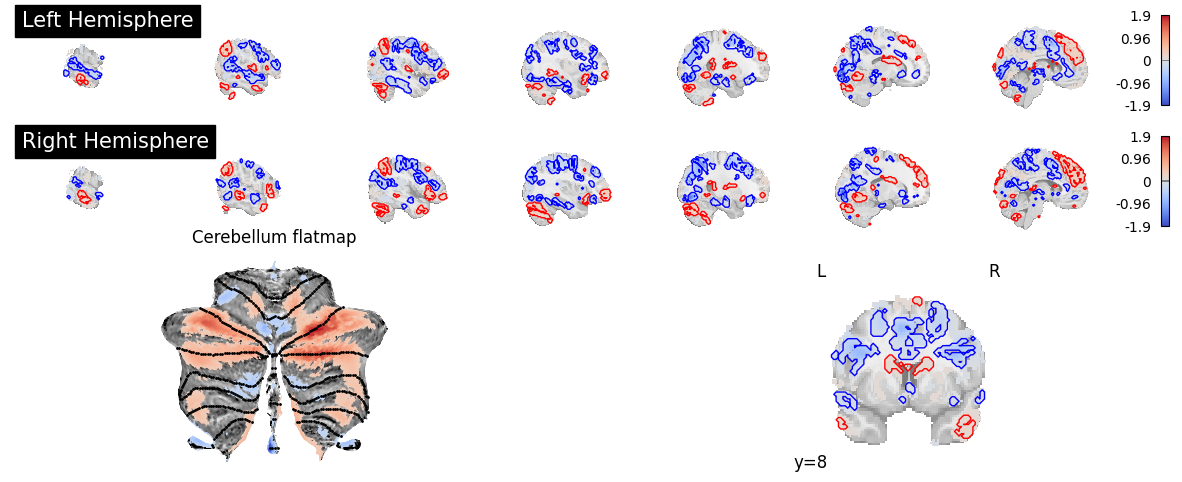

In [6]:
filename = data_dir+'/group/'+'not_asd_SR_ButtonPress'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

### Reward Prediction Error

/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(
/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


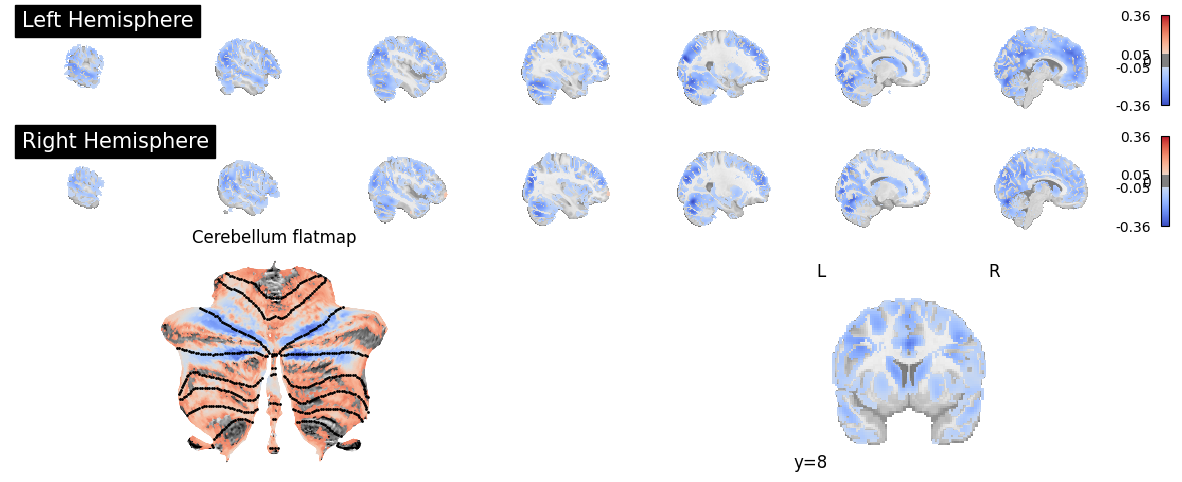

In [7]:
filename = data_dir+'/group/'+'not_asd_SR_RPE'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)

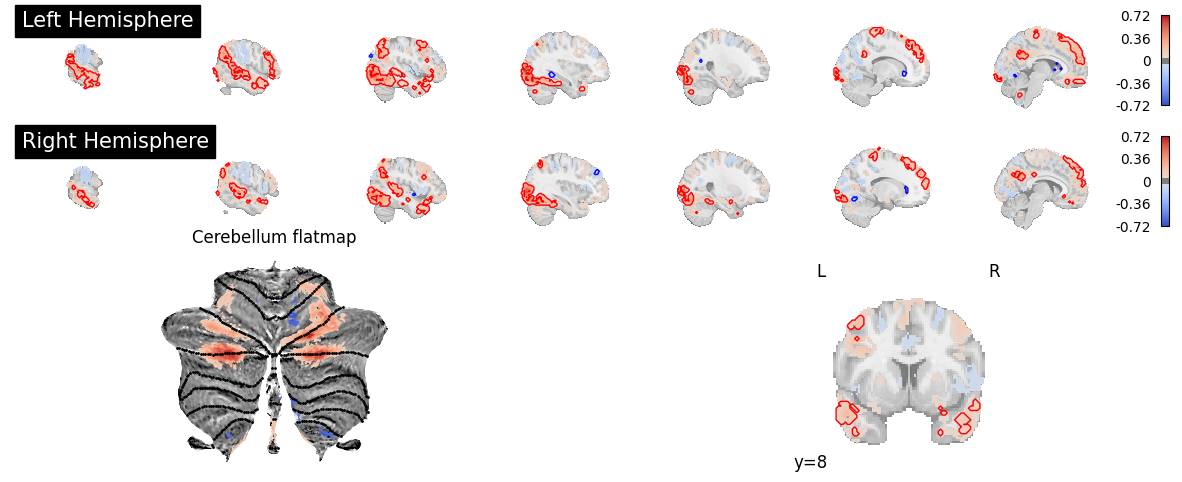

In [8]:
filename = data_dir+'/group/'+'not_asd_SR_RPE_abs'

helpful_functions.plot_transparent_threshold(filename, thresh=.05, mc_alpha=0.005)